<a href="https://colab.research.google.com/github/ma75442/HE_Get-a-room-ML-Hackathon-/blob/main/Clusturing_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.feature_selection import f_regression
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
import numpy as npz
import os
import seaborn as sns
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# from catboost import CatBoostRegressor
# !pip install lightgbm
from lightgbm import LGBMRegressor
# !pip install xgboost

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE


%matplotlib inline
pd.set_option('float_format', '{:f}'.format)

In [11]:
train = pd.read_csv('sample_data/train.csv')
train.head()




,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.000000,No,Once in a day - Morning,5.890000,Slightly below average,Medium,90.000000,3.860000,71.980000
1,0x68d4,Apartment,733,2.000000,2,Unfurnished,1.000000,No,Once in a day - Evening,4.370000,Well below average,Medium,96.000000,3.550000,71.200000
2,0x7d81,Apartment,737,4.000000,2,Fully Furnished,0.000000,No,Once in a day - Morning,7.450000,Slightly below average,Medium,121.000000,3.810000,71.390000
3,0x7a57,Apartment,900,3.000000,2,Unfurnished,2.000000,Yes,Once in a day - Morning,6.160000,Well above average,Medium,100.000000,1.340000,31.460000
4,0x9409,Bungalow,2238,14.000000,6,Fully Furnished,0.000000,No,All time,5.460000,Well below average,Medium,116.000000,4.770000,93.700000


In [12]:
train_pt = train[['Property_Type','Property_Area','Number_of_Doors']]
train_pt = train_pt[~train_pt['Property_Type'].isin(["#R%$G&867"])]
# train_pt = train[['Number_of_Windows','Number_of_Doors','Property_Area']]
train_pt.dropna(inplace=True) 
# # train_pt['Property_Type'].unique()

train_pt['Property_Type'].replace(['Apartment', 'Bungalow', 'Single-family home', 'Duplex','Container Home'], [0,1,2,3,4],inplace=True)

#train_pt['Number_of_Windows'] = train_pt['Number_of_Windows'].astype("int64")


In [13]:
train_pt.head()
# train_pt.shape
# train_pt.info()
# train_pt.describe()

,Property_Type,Property_Area,Number_of_Doors
0,0,106,1
1,0,733,2
2,0,737,2
3,0,900,2
4,1,2238,6


Text(0, 0.5, 'WCSS')

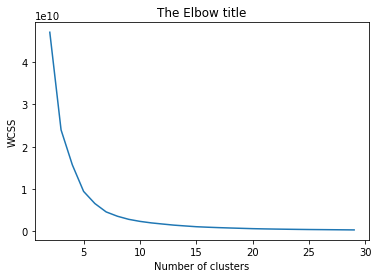

In [6]:
# # Finding optimal numbers of clustures 
# from sklearn.cluster import KMeans
# wcss=[]
# for i in range(2,30):
#     kmeans = KMeans(i)
#     kmeans.fit(train_pt)
#     wcss_iter = kmeans.inertia_
#     wcss.append(wcss_iter)

# number_clusters = range(2,30)
# plt.plot(number_clusters,wcss)
# plt.title('The Elbow title')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')


# 18 will be fine 

In [14]:
# train_pt
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=9)
Kmean.fit(train_pt.drop('Property_Type',axis=1))
Kmean.labels_

train_pt['cluster'] = Kmean.labels_
train_ptTemp = train_pt[["Property_Area",	"Number_of_Doors",	"cluster"]]
train_ptTemp = (train_ptTemp-train_ptTemp.min())/(train_ptTemp.max()-train_ptTemp.min())
train_pt[["Property_Area",	"Number_of_Doors",	"cluster"]] = train_ptTemp[["Property_Area",	"Number_of_Doors",	"cluster"]]
train_pt

,Property_Type,Property_Area,Number_of_Doors,cluster
0,0,0.000215,0.000000,0.750000
1,0,0.022636,0.200000,0.000000
2,0,0.022779,0.200000,0.000000
3,0,0.028608,0.200000,0.000000
4,1,0.076455,1.000000,0.250000
...,...,...,...,...
39494,2,0.036475,0.200000,0.875000
39495,0,0.012337,0.400000,0.750000
39496,1,0.131598,1.000000,0.625000
39497,2,0.041696,0.000000,0.875000


test data

In [15]:
test = pd.read_csv('sample_data/testa.csv')
test_pt = test[['Property_ID',"Property_Type"	,"Property_Area",	"Number_of_Doors"]]

#test_pt = test_pt[~test_pt['Number_of_Windows'].isna()]
test_pt = test_pt[test_pt['Property_Type'].isin(["#R%$G&867"])]
test_pt = test_pt[['Property_ID',"Property_Area",	"Number_of_Doors"]]
#test_pt['Number_of_Windows'] = test_pt['Number_of_Windows'].astype("int64")
test_pt.info()
test_pt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 386 to 10203
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Property_ID      10 non-null     object
 1   Property_Area    10 non-null     int64 
 2   Number_of_Doors  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 320.0+ bytes


,Property_ID,Property_Area,Number_of_Doors
386,0x1570,1265,3
1779,0x7e40,1379,2
3924,0x9d79,968,3
4307,0x1a75,865,3
5580,0xb97a,514,3


In [16]:
test_pt3 = test_pt[["Property_Area"	,"Number_of_Doors"]]
test_pt3_clusture = Kmean.fit_predict(test_pt3)
test_pt3.info()
test_pt3['cluster'] = test_pt3_clusture
test_pt3 = (test_pt3-test_pt3.min())/(test_pt3.max()-test_pt3.min())
test_pt3['Property_ID'] = test_pt['Property_ID']
test_pt3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 386 to 10203
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Property_Area    10 non-null     int64
 1   Number_of_Doors  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes


,Property_Area,Number_of_Doors,cluster,Property_ID
386,0.208437,0.666667,0.375000,0x1570
1779,0.240078,0.333333,1.000000,0x7e40
3924,0.126006,0.666667,0.625000,0x9d79
4307,0.097419,0.666667,0.625000,0x1a75
5580,0.000000,0.666667,0.000000,0xb97a


In [17]:
from operator import index
from tkinter import NW

progress = 0

test_pt
# train_pt
# finding proprty id using euclidien distance 
ans = pd.DataFrame([])
for itest in test_pt3.index:
    # print(itest)
    min_ed = 1000000
    pt = ""
    for itrain in train_pt.index:
        pa = np.square(test_pt3.loc[itest,'Property_Area']-train_pt.loc[itrain,'Property_Area'])
        #nw = np.square(test_pt3.loc[itest,'Number_of_Windows']-train_pt.loc[itrain,'Number_of_Windows'])
        nd = np.square(test_pt3.loc[itest,'Number_of_Doors']-train_pt.loc[itrain,'Number_of_Doors'])
        cl = np.square(test_pt3.loc[itest,'cluster']-train_pt.loc[itrain,'cluster'])
        dist = np.sqrt(pa+nd+cl)
        # print(pa,nw,nd,cl,dist) 
        if(min_ed>dist):
            min_ed=dist
            pt = train_pt.loc[itrain,'Property_Type']
            # print(min_ed,pt)
    pro_ty = test_pt3.loc[itest,'Property_ID']
    # print(list(zip([pro_ty],[pt])))
    data = {"Property ID":[pro_ty],"Pro ty":[pt]} 
    # temp = pd.DataFrame(list(([pro_ty],[pt])))
    temp  = pd.DataFrame(data)
    ans = ans.append(temp)
    print(progress)
    progress = progress+1


0
1
2
3
4
5
6
7
8
9


In [18]:
# test_pt
# train_pt
ans.to_excel("Clusture of Property type 10.xlsx")

In [ ]:
ans

,Property ID,Pro ty
0,0x6b21,Single-family home
0,0x2cf7,Bungalow
0,0xb583,Single-family home
0,0x8873,Duplex
0,0x9791,Apartment
...,...,...
0,0x552f,Bungalow
0,0x8de6,Apartment
0,0x5b32,Duplex
0,0xb2f8,Apartment


<h2> Clusturing of Number of Windows </h2>

In [27]:
train = pd.read_csv('sample_data/train.csv')
train.head()




,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.000000,No,Once in a day - Morning,5.890000,Slightly below average,Medium,90.000000,3.860000,71.980000
1,0x68d4,Apartment,733,2.000000,2,Unfurnished,1.000000,No,Once in a day - Evening,4.370000,Well below average,Medium,96.000000,3.550000,71.200000
2,0x7d81,Apartment,737,4.000000,2,Fully Furnished,0.000000,No,Once in a day - Morning,7.450000,Slightly below average,Medium,121.000000,3.810000,71.390000
3,0x7a57,Apartment,900,3.000000,2,Unfurnished,2.000000,Yes,Once in a day - Morning,6.160000,Well above average,Medium,100.000000,1.340000,31.460000
4,0x9409,Bungalow,2238,14.000000,6,Fully Furnished,0.000000,No,All time,5.460000,Well below average,Medium,116.000000,4.770000,93.700000


In [28]:
train_pt = train[['Property_Type','Number_of_Windows','Number_of_Doors']]
train_pt = train_pt[~train_pt['Property_Type'].isin(["#R%$G&867"])]
# train_pt = train[['Number_of_Windows','Number_of_Doors','Property_Area']]
train_pt.dropna(inplace=True) 
# # train_pt['Property_Type'].unique()

train_pt['Property_Type'].replace(['Apartment', 'Bungalow', 'Single-family home', 'Duplex',
       'Container Home'], [0,1,2,3,4],inplace=True)

train_pt['Number_of_Windows'] = train_pt['Number_of_Windows'].astype("int64")


In [29]:
train_pt.head()

,Property_Type,Number_of_Windows,Number_of_Doors
1,0,2,2
2,0,4,2
3,0,3,2
4,1,14,6
5,2,3,3


In [24]:
# Finding optimal numbers of clustures 
# from sklearn.cluster import KMeans
# wcss=[]
# for i in range(2,10):
#     kmeans = KMeans(i)
#     kmeans.fit(train_pt.drop('Number_of_Windows',axis=1))
#     wcss_iter = kmeans.inertia_
#     wcss.append(wcss_iter)

# number_clusters = range(2,30)
# plt.plot(number_clusters,wcss)
# plt.title('The Elbow title')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')


# 18 will be fine a

In [25]:
train_pt.head()

,Property_Type,Number_of_Windows,Number_of_Doors
1,0,2,2
2,0,4,2
3,0,3,2
4,1,14,6
5,2,3,3


In [31]:
# train_pt
# from sklearn.cluster import KMeans
# Kmean = KMeans(n_clusters=9)
# Kmean.fit(train_pt.drop('Number_of_Windows',axis=1))
# Kmean.labels_

# train_pt['cluster'] = Kmean.labels_
# train_pt['cluster'].head()
train_ptTemp = train_pt[["Property_Type","Number_of_Doors",	"cluster"]]
train_ptTemp = (train_ptTemp-train_ptTemp.min())/(train_ptTemp.max()-train_ptTemp.min())
train_pt[["Property_Type",	"Number_of_Doors",	"cluster"]] = train_ptTemp[["Property_Type",	"Number_of_Doors",	"cluster"]]
train_pt.head()

,Property_Type,Number_of_Windows,Number_of_Doors,cluster
1,0.000000,2,0.200000,0.625000
2,0.000000,4,0.200000,0.625000
3,0.000000,3,0.200000,0.625000
4,0.250000,14,1.000000,0.750000
5,0.500000,3,0.400000,0.500000


In [33]:
# test 
test = pd.read_csv('sample_data/testa.csv')
test_pt = test[['Property_ID',"Property_Type"	,"Number_of_Windows",	"Number_of_Doors"]]

test_pt = test_pt[test_pt['Number_of_Windows'].isna()]
#test_pt = test_pt[~test_pt['Property_Type'].isin(["#R%$G&867"])]
test_pt = test_pt[['Property_ID',"Property_Type","Number_of_Windows",	"Number_of_Doors"]]
# test_pt['Number_of_Windows'] = test_pt['Number_of_Windows'].astype("int64")
test_pt.info()
test_pt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 386 to 10203
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Property_ID        10 non-null     object 
 1   Property_Type      10 non-null     object 
 2   Number_of_Windows  0 non-null      float64
 3   Number_of_Doors    10 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 400.0+ bytes


,Property_ID,Property_Type,Number_of_Windows,Number_of_Doors
386,0x1570,Single-family home,NaN,3
1779,0x7e40,Single-family home,NaN,2
3924,0x9d79,Duplex,NaN,3
4307,0x1a75,Duplex,NaN,3
5580,0xb97a,Single-family home,NaN,3


In [34]:
test_pt['Property_Type'].replace(['Apartment', 'Bungalow', 'Single-family home', 'Duplex',
       'Container Home'], [0,1,2,3,4],inplace=True)
test_pt3 = test_pt[["Property_Type"	,"Number_of_Doors"]]
test_pt3_clusture = Kmean.fit_predict(test_pt3)
test_pt3.info()
test_pt3['cluster'] = test_pt3_clusture
test_pt3 = (test_pt3-test_pt3.min())/(test_pt3.max()-test_pt3.min())
test_pt3['Property_ID'] = test_pt['Property_ID']
test_pt3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 386 to 10203
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Property_Type    10 non-null     int64
 1   Number_of_Doors  10 non-null     int64
dtypes: int64(2)
memory usage: 240.0 bytes


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Property_Type,Number_of_Doors,cluster,Property_ID
386,0.500000,0.666667,0.000000,0x1570
1779,0.500000,0.333333,1.000000,0x7e40
3924,1.000000,0.666667,0.571429,0x9d79
4307,1.000000,0.666667,0.571429,0x1a75
5580,0.500000,0.666667,0.000000,0xb97a


In [35]:
from operator import index
from tkinter import NW

progress = 0

test_pt
# train_pt
# finding proprty id using euclidien distance 
ans = pd.DataFrame([])
for itest in test_pt3.index:
    # print(itest)
    min_ed = 1000000
    nw = 0
    for itrain in train_pt.index:
        pt = np.square(test_pt3.loc[itest,'Property_Type']-train_pt.loc[itrain,'Property_Type'])
        nd = np.square(test_pt3.loc[itest,'Number_of_Doors']-train_pt.loc[itrain,'Number_of_Doors'])
        cl = np.square(test_pt3.loc[itest,'cluster']-train_pt.loc[itrain,'cluster'])
        dist = np.sqrt(pt+nd+cl)
        # print(pa,nw,nd,cl,dist) 
        if(min_ed>dist):
            min_ed=dist
            nw = train_pt.loc[itrain,'Number_of_Windows']
            # print(min_ed,pt)
    pro_ID = test_pt3.loc[itest,'Property_ID']
    # print(list(zip([pro_ty],[pt])))
    data = {"Property ID":[pro_ID],"No Windw":[nw]} 
    # temp = pd.DataFrame(list(([pro_ty],[pt])))
    temp  = pd.DataFrame(data)
    ans = ans.append(temp)
    print(ans)
    print(progress,test_pt3.shape)
    progress = progress+1


  Property ID  No Windw
0      0x1570         3
0 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
1 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79         5
2 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79         5
0      0x1a75         5
3 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79         5
0      0x1a75         5
0      0xb97a         3
4 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79         5
0      0x1a75         5
0      0xb97a         3
0      0x4361        14
5 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79         5
0      0x1a75         5
0      0xb97a         3
0      0x4361        14
0      0x9763         3
6 (10, 4)
  Property ID  No Windw
0      0x1570         3
0      0x7e40         2
0      0x9d79     

# Clustering for Crime rate

In [ ]:
train = pd.read_csv('sample_data/train.csv')
train.head()

In [ ]:
train_pt = train[['Crime_Rate','Neighborhood_Review','Traffic_Density_Score']]
train_pt = train_pt[~train_pt['Crime_Rate'].isna()]
# train_pt = train[['Number_of_Windows','Number_of_Doors','Property_Area']]
train_pt.dropna(inplace=True) 
# # train_pt['Property_Type'].unique()

#train_pt['Property_Type'].replace(['Slightly below average', 'Well below average', 'Single-family home', 'Duplex',
     #  'Container Home'], [0,1,2,3,4],inplace=True)
train_pt.head()
#train_pt['Number_of_Windows'] = train_pt['Number_of_Windows'].astype("int64")

In [ ]:
train_pt.info()

In [ ]:
# Finding optimal numbers of clustures 
from sklearn.cluster import KMeans
wcss=[]
for i in range(2,50):
    kmeans = KMeans(i)
    kmeans.fit(train_pt.drop('Crime_Rate',axis=1))
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(2,50)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# 48 is best cluster

In [ ]:
# train_pt
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=48)
Kmean.fit(train_pt.drop('Crime_Rate',axis=1))
Kmean.labels_

train_pt['cluster'] = Kmean.labels_
#train_pt['cluster'].head()
train_ptTemp = train_pt[['Neighborhood_Review','Traffic_Density_Score',	"cluster"]]
train_ptTemp = (train_ptTemp-train_ptTemp.min())/(train_ptTemp.max()-train_ptTemp.min())
train_pt[['Neighborhood_Review','Traffic_Density_Score',	"cluster"]] = train_ptTemp[['Neighborhood_Review','Traffic_Density_Score',	"cluster"]]
train_pt.head()

In [ ]:
# test 
test = pd.read_csv('sample_data/testa.csv')
test_pt = test[['Crime_Rate','Neighborhood_Review','Traffic_Density_Score']]

test_pt = test_pt[test_pt['Crime_Rate'].isna()]
#test_pt = test_pt[['Crime_Rate','Neighborhood_Review','Traffic_Density_Score']]
# test_pt['Number_of_Windows'] = test_pt['Number_of_Windows'].astype("int64")
test_pt.info()
test_pt.head()

In [ ]:
#test_pt['Crime_Rate'].replace(['Apartment', 'Bungalow', 'Single-family home', 'Duplex',
   #    'Container Home'], [0,1,2,3,4],inplace=True)
test_pt3 = test_pt[['Neighborhood_Review','Traffic_Density_Score']]
test_pt3_clusture = Kmean.fit_predict(test_pt3)
test_pt3.info()
test_pt3['cluster'] = test_pt3_clusture
test_pt3 = (test_pt3-test_pt3.min())/(test_pt3.max()-test_pt3.min())
test_pt3['Property_ID'] = test['Property_ID']
test_pt3.head()

In [ ]:
from operator import index
from tkinter import NW

progress = 0

test_pt
# train_pt
# finding proprty id using euclidien distance 
ans = pd.DataFrame([])
for itest in test_pt3.index:
    # print(itest)
    min_ed = 1000000
    cr = ""
    for itrain in train_pt.index:
        nr = np.square(test_pt3.loc[itest,'Neighborhood_Review']-train_pt.loc[itrain,'Neighborhood_Review'])
        tds = np.square(test_pt3.loc[itest,'Traffic_Density_Score']-train_pt.loc[itrain,'Traffic_Density_Score'])
        cl = np.square(test_pt3.loc[itest,'cluster']-train_pt.loc[itrain,'cluster'])
        dist = np.sqrt(nr+tds+cl)
        # print(pa,nw,nd,cl,dist) 
        if(min_ed>dist):
            min_ed=dist
            cr = train_pt.loc[itrain,'Crime_Rate']
            # print(min_ed,pt)
    pro_ID = test_pt3.loc[itest,'Property_ID']
    # print(list(zip([pro_ty],[pt])))
    data = {"Property ID":[pro_ID],"crime_rate":[cr]} 
    # temp = pd.DataFrame(list(([pro_ty],[pt])))
    temp  = pd.DataFrame(data)
    ans = ans.append(temp)
    print(ans)
    print(progress,test_pt3.shape)
    progress = progress+1

In [56]:
ans.to_csv('crime_rate_clean.csv')

# Clustoring for Dust_noise

In [57]:
train = pd.read_csv('sample_data/train.csv')
train.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.000000,No,Once in a day - Morning,5.890000,Slightly below average,Medium,90.000000,3.860000,71.980000
1,0x68d4,Apartment,733,2.000000,2,Unfurnished,1.000000,No,Once in a day - Evening,4.370000,Well below average,Medium,96.000000,3.550000,71.200000
2,0x7d81,Apartment,737,4.000000,2,Fully Furnished,0.000000,No,Once in a day - Morning,7.450000,Slightly below average,Medium,121.000000,3.810000,71.390000
3,0x7a57,Apartment,900,3.000000,2,Unfurnished,2.000000,Yes,Once in a day - Morning,6.160000,Well above average,Medium,100.000000,1.340000,31.460000
4,0x9409,Bungalow,2238,14.000000,6,Fully Furnished,0.000000,No,All time,5.460000,Well below average,Medium,116.000000,4.770000,93.700000


In [58]:
train_pt = train[['Dust_and_Noise','Air_Quality_Index','Traffic_Density_Score']]
train_pt = train_pt[~train_pt['Dust_and_Noise'].isna()]
# train_pt = train[['Number_of_Windows','Number_of_Doors','Property_Area']]
train_pt.dropna(inplace=True) 
# # train_pt['Property_Type'].unique()

#train_pt['Property_Type'].replace(['Slightly below average', 'Well below average', 'Single-family home', 'Duplex',
     #  'Container Home'], [0,1,2,3,4],inplace=True)
train_pt.head()

,Dust_and_Noise,Air_Quality_Index,Traffic_Density_Score
0,Medium,90.000000,5.890000
1,Medium,96.000000,4.370000
2,Medium,121.000000,7.450000
3,Medium,100.000000,6.160000
4,Medium,116.000000,5.460000


Text(0, 0.5, 'WCSS')

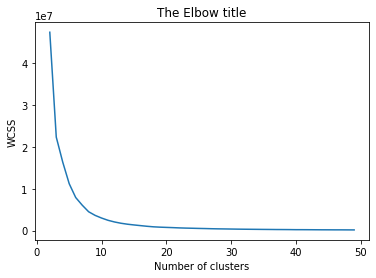

In [59]:
# Finding optimal numbers of clustures 
from sklearn.cluster import KMeans
wcss=[]
for i in range(2,50):
    kmeans = KMeans(i)
    kmeans.fit(train_pt.drop('Dust_and_Noise',axis=1))
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(2,50)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# 20 is best cluster

In [61]:
# train_pt
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=20)
Kmean.fit(train_pt.drop('Dust_and_Noise',axis=1))
Kmean.labels_

train_pt['cluster'] = Kmean.labels_
#train_pt['cluster'].head()
train_ptTemp = train_pt[['Air_Quality_Index','Traffic_Density_Score',	"cluster"]]
train_ptTemp = (train_ptTemp-train_ptTemp.min())/(train_ptTemp.max()-train_ptTemp.min())
train_pt[['Air_Quality_Index','Traffic_Density_Score',	"cluster"]] = train_ptTemp[['Air_Quality_Index','Traffic_Density_Score',	"cluster"]]
train_pt.head()

,Dust_and_Noise,Air_Quality_Index,Traffic_Density_Score,cluster
0,Medium,0.086207,0.594349,0.157895
1,Medium,0.091954,0.440969,0.157895
2,Medium,0.115900,0.751766,0.947368
3,Medium,0.095785,0.621594,0.526316
4,Medium,0.111111,0.550959,0.000000


In [60]:
# test 
test = pd.read_csv('sample_data/testa.csv')
test_pt = test[['Dust_and_Noise','Air_Quality_Index','Traffic_Density_Score']]

test_pt = test_pt[test_pt['Dust_and_Noise'].isna()]
#test_pt = test_pt[['Crime_Rate','Neighborhood_Review','Traffic_Density_Score']]
# test_pt['Number_of_Windows'] = test_pt['Number_of_Windows'].astype("int64")
test_pt.info()
test_pt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 113 to 10494
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Dust_and_Noise         0 non-null      object 
 1   Air_Quality_Index      330 non-null    int64  
 2   Traffic_Density_Score  330 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.3+ KB


,Dust_and_Noise,Air_Quality_Index,Traffic_Density_Score
113,NaN,113,4.870000
241,NaN,168,6.530000
253,NaN,108,4.590000
338,NaN,97,5.790000
353,NaN,85,6.400000


In [62]:
test_pt3 = test_pt[['Air_Quality_Index','Traffic_Density_Score']]
test_pt3_clusture = Kmean.fit_predict(test_pt3)
test_pt3.info()
test_pt3['cluster'] = test_pt3_clusture
test_pt3 = (test_pt3-test_pt3.min())/(test_pt3.max()-test_pt3.min())
test_pt3['Property_ID'] = test['Property_ID']
test_pt3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 113 to 10494
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Air_Quality_Index      330 non-null    int64  
 1   Traffic_Density_Score  330 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.7 KB


,Air_Quality_Index,Traffic_Density_Score,cluster,Property_ID
113,0.138101,0.398936,0.157895,0x9495
241,0.205919,0.619681,0.315789,0x51e6
253,0.131936,0.361702,0.789474,0x1a65
338,0.118372,0.521277,0.736842,0x43c4
353,0.103576,0.602394,0.105263,0x3a5b


In [63]:
from operator import index
from tkinter import NW

progress = 0

test_pt
# train_pt
# finding proprty id using euclidien distance 
ans = pd.DataFrame([])
for itest in test_pt3.index:
    # print(itest)
    min_ed = 1000000
    dn = ""
    for itrain in train_pt.index:
        nr = np.square(test_pt3.loc[itest,'Air_Quality_Index']-train_pt.loc[itrain,'Air_Quality_Index'])
        tds = np.square(test_pt3.loc[itest,'Traffic_Density_Score']-train_pt.loc[itrain,'Traffic_Density_Score'])
        cl = np.square(test_pt3.loc[itest,'cluster']-train_pt.loc[itrain,'cluster'])
        dist = np.sqrt(nr+tds+cl)
        # print(pa,nw,nd,cl,dist) 
        if(min_ed>dist):
            min_ed=dist
            dn = train_pt.loc[itrain,'Dust_and_Noise']
            # print(min_ed,pt)
    pro_ID = test_pt3.loc[itest,'Property_ID']
    # print(list(zip([pro_ty],[pt])))
    data = {"Property ID":[pro_ID],"Dust_and_Noise":[dn]} 
    # temp = pd.DataFrame(list(([pro_ty],[pt])))
    temp  = pd.DataFrame(data)
    ans = ans.append(temp)
    print(ans)
    print(progress,test_pt3.shape)
    progress = progress+1

Streaming output truncated to the last 5000 lines.
0      0x8199         Medium
0      0x4258         Medium
0      0x863f         Medium
0      0x453b         Medium
0       0xf1e         Medium
0      0x850b         Medium
0      0x83c2         Medium
0      0x534d         Medium
0      0x2d16         Medium
0      0x687e         Medium
0       0x8cc         Medium
0      0xb284         Medium
0      0xb28c           High
0      0x9311         Medium
0      0x852d         Medium
0      0xb229         Medium
0      0x4de5            Low
0      0x9bd4         Medium
0      0x7839         Medium
0      0x4d45         Medium
0       0x6d8            Low
0      0x1d88         Medium
0      0x1e4b         Medium
0      0x11c3         Medium
0      0x79cf         Medium
0      0x8351           High
0      0x5737            Low
0      0x2f32         Medium
0      0xac42         Medium
0      0x2bb9            Low
0      0x5ceb            Low
42 (330, 4)
  Property ID Dust_and_Noise
0      0x

In [64]:
ans.to_csv('dust_noise_clean.csv')